In [1]:
import datetime

date_time = datetime.datetime.now()

In [2]:
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore

import numpy as np
from collections import defaultdict
from scipy.optimize import curve_fit

import re
import sys
import string

def powerSeriesFilterting(vodString, credentialID):

    cred = credentials.Certificate(credentialID)

    # Check if the default app already exists
    # Try to get the default Firebase app
    try:
        default_app = firebase_admin.get_app()
        print("Default app already exists.")
    except ValueError as e:
        print("Default app does not exist. Initializing a new one.")
        firebase_admin.initialize_app(cred)
    # Initialize Firestore database client
    db = firestore.client()

    # Specify the collection to retrieve documents from and the number of documents to retrieve
    collection_ref = db.collection("Livestreams")

    # basic Power_law distribution
    def power_law(x, a, b):
        return a * np.power(x, b)

    def power_law_approximation(x, y):
        params, params_covariance = curve_fit(power_law, x, y)
        a = params[0]
        b = params[1]
        return a, b

    def get_key_value_lists(dictionary):
        keys = []
        values = []
        for i, (key, value) in enumerate(dictionary.items()):
            keys.append(i)
            values.append(value)
        return keys, values

    def count_string_occurrences(list_of_sets):
        occurrences = defaultdict(int)

        # Count the occurrences of each string in the list of sets
        for set_of_strings in list_of_sets:
            for string in set_of_strings:
                occurrences[string] += 1

        # Sort the dictionary based on the count of occurrences
        sorted_occurrences = dict(sorted(occurrences.items(), key=lambda x: x[1], reverse=True))

        return sorted_occurrences

    def retreiveChatData(numberOfVods):

        n_docs_to_retrieve = numberOfVods  # Change this to the desired number of documents to retrieve

        # Iterate over the first n documents in the collection
        docs = collection_ref.limit(n_docs_to_retrieve).stream()

        # Basic lists to store data in
        streamIDList = []
        multipleStreamVODChatList = {}

        # Select a list of document ID's to reference
        for doc in docs:
            doc_id = doc.id
            streamIDList.append(doc_id)

        # Download the ChatLogs as dictionaries and load a variable.
        for ids in streamIDList:

            sub_collection_ref = db.collection("Livestreams").document(ids).collection('ChatLogs')
            chat_logs = sub_collection_ref.stream()

            totalChatLog = []

            for chat_log in chat_logs:
                totalChatLog = totalChatLog + chat_log.to_dict()["Chats"]

            # adjust messages to only have relevant data

            totalChatLog = [chats for chats in totalChatLog if process_string(chats["message"])]

            for chats in totalChatLog:
                chats["message"] = process_string(chats["message"])


            list_size = sys.getsizeof(totalChatLog)
            print(f"List size: {list_size} bytes")

            # Create a finalList of lists of message objects in
            multipleStreamVODChatList[ids] = totalChatLog

        return multipleStreamVODChatList
        # From here on out, we can use the StreamVodChatList to examine multiple unique VOD chats, compare if needed.

    def process_string(input_string):
        # Translation table to replace ":" with a space
        translation_table = str.maketrans({":": " "})

        # Create a set to store unique words
        unique_words = set()

        # Iterate over words in the input string
        for word in input_string.translate(translation_table).split():
            # Check if the word has at least one capitalized character
            if any(c.isupper() for c in word):
                # Add the word to the set of unique words
                unique_words.add(word)

        # Return the unique words as a string
        return " ".join(unique_words)

    def analyzeSpecificVod(livestreamURL):


        regex_youtube = r"^https:\/\/www\.youtube\.com\/watch\?v=([\w_-]{11}).*$"
        regex_twitch = r"^https:\/\/www\.twitch\.tv\/videos\/(\d{10}).*$"

        vod_id = "invalid URL"

        if re.match(regex_youtube, livestreamURL):

            vod_id = re.match(regex_youtube, livestreamURL)[1]
            website = 'Youtube'

            player_url = f'https://www.youtube.com/embed/{vod_id}?autoplay=1'

        elif re.match(regex_twitch, livestreamURL):

            vod_id = re.match(regex_twitch, livestreamURL)[1]
            website = 'Twitch'

            player_url = f'https://player.twitch.tv/?video=v{vod_id}&parent=kentauroscomputing.com&autoplay=False'

            sub_collection_ref = db.collection("Livestreams").document(vod_id).collection('ChatLogs')
            chat_logs = sub_collection_ref.stream()

            totalChatLog = []

            for chat_log in chat_logs:
                totalChatLog = totalChatLog + chat_log.to_dict()["Chats"]

            return totalChatLog

    def retreiveSpecificChat(vodID):

        collection_ref = db.collection("Livestreams").document(vodID).collection('ChatLogs')
        chat_logs = collection_ref.stream()
        # Download the ChatLogs as dictionaries and load a variable.

        totalChatLog = []

        for chat_log in chat_logs:
            totalChatLog = totalChatLog + chat_log.to_dict()["Chats"]

        # adjust messages to only have relevant data

        totalChatLog = [chats for chats in totalChatLog if process_string(chats["message"])]

        for chats in totalChatLog:
            chats["message"] = process_string(chats["message"])

        return totalChatLog
        # From here on out, we can use the StreamVodChatList to examine multiple unique VOD chats, compare if needed.

    def convertDurationToBinnedHistogram(startTime,duration,binTime, chatLog):

        durationSeries = list(np.arange(startTime,duration, binTime)) # remove bin lengths
        binnedchatLogs = {binKey: [] for binKey in durationSeries}

        punctuation_without_colon = "".join(c for c in string.punctuation if c != ':')
        translator = str.maketrans("","", punctuation_without_colon) # List of all punctuations that need to be removed

        # iterate through the list and adjust the data to better be analyzed
        for chatMessage in chatLog:

            # adjust the wordlist to be a set of relevant words
            wordList = chatMessage["message"].translate(translator)
            wordList = wordList.split()
            wordList = set(wordList)

            messageBinPosition = chatMessage["timestamp"] - chatMessage["timestamp"] % vodData["binSize"]
            binnedchatLogs[messageBinPosition].append(wordList)

        return chatLog, binnedchatLogs

    def returnPowerDistributionConstantData(binnedHistogramWordSets, plotsWanted, vodIDStringExpected):

        fileNum = 0
        a_values = []
        b_values = []
        labeledData = []

        for binnedHistogramIndex in binnedHistogramWordSets:

            fileName = str(fileNum) + "_" + vodIDStringExpected + '_' + str(binnedHistogramIndex)

            x_values, y_values = get_key_value_lists(binnedHistogramWordSets[binnedHistogramIndex])
            x_values = [x + 1 for x in x_values]

            if len(x_values) > 1:

                a,b = power_law_approximation(x_values, y_values)
                a_values.append(a)
                b_values.append(b)

                labeledData.append({"a":a, "b":b,"label":fileNum, "timeStamp":binnedHistogramIndex})

            fileNum = fileNum + 1

        return labeledData, a_values, b_values

    def binnedChats2PowerDistributionDict(binnedHistogramWordSets):

        for binnedHistogramIndex in binnedHistogramWordSets:

            binnedHistogramWordSets[binnedHistogramIndex] = count_string_occurrences(binnedHistogramWordSets[binnedHistogramIndex])

        return binnedHistogramWordSets

    def conditionalPlotPrint(labeledData, a_cutoff, binnedHistogramWordSets, plotsWanted):

        filteredLabeledData = []
        filteredPowerDist = []
        a_filtered = []
        b_filtered = []

        for binSegments in labeledData:

            apass = binSegments["a"] >= a_cutoff
            bpass = binSegments["b"] <= -0.01

            if (apass & bpass):

                filteredPowerDist.append(binnedHistogramWordSets[binSegments["timeStamp"]])

                filteredLabeledData.append(binSegments)
                a_filtered.append(binSegments["a"])
                b_filtered.append(binSegments["b"])

                fileName = str(binSegments["timeStamp"])

                x_values, y_values = get_key_value_lists(binnedHistogramWordSets[binSegments["timeStamp"]])
                x_values = [x + 1 for x in x_values]

        return filteredLabeledData, filteredPowerDist, a_filtered, b_filtered

    def CutoffAValue(threshold, a_index_denominator, seriesValues):

        a_without_ones = sorted([constants for constants in seriesValues if constants >= threshold], reverse=True)
        a_index = int(round(len(a_without_ones)/a_index_denominator))

        a_cutoff = a_without_ones[a_index]

        return a_cutoff
    # ---------Return Filtered Data -------------
    def return_time_stamp_list(filteredData):

        timeStampfiltered = []
        for i in filteredData:
            timeStampfiltered.append(i['timeStamp'])

        return timeStampfiltered

    def generate_number_ranges(numbers, constant):

        ranges = []
        for num in numbers:
            ranges.append((round(num,4), round(num + constant,4)))
        return ranges

    def combine_overlapping_ranges(ranges):
        combined_ranges = []
        if not ranges:
            return combined_ranges

        ranges.sort(key=lambda x: x[0])  # Sort the ranges based on the starting value

        start, end = ranges[0]
        for i in range(1, len(ranges)):
            next_start, next_end = ranges[i]
            if next_start <= end:
                # There is an overlap, update the end value
                end = max(end, next_end)
            else:
                # No overlap, add the current range to the combined_ranges
                combined_ranges.append((start, end))
                start, end = next_start, next_end

        combined_ranges.append((start, end))  # Add the last range

        return combined_ranges

    def filter_dicts_by_time(a, time_ranges):
        filtered_list = []

        for item in a:
            timestamp = item.get("timestamp")

            if timestamp:
                for start, end in time_ranges:
                    if start <= timestamp <= end:
                        filtered_list.append(item)
                        break

        return filtered_list
    # --------------------------------------

    """
    vodIDStringMinimum = '1810011271' # The minimum needed for sufficient data to draw conclusions (15 chats per Min)
    vodIDStringExpected = '1823236342' # The expected chat logs we'd most likely receive (24 chats per Min)
    vodIdString_99Perc = '1816825048' # The Chat that would cover 99.99% of chats (86 chats per Min)

    vodString = vodIDStringExpected
     """

    chatLog = retreiveSpecificChat(vodString)

    vodData = { # Units are in minutes
        'startTime': 0,
        'duration': chatLog[-1]['timestamp'],
        'binSize': (1/3),
    }

    # clean the chat data, convert chat data into binned times and put in same list
    cleanedChatLog, binnedHistogramWordSets = convertDurationToBinnedHistogram(vodData["startTime"], vodData["duration"] + vodData["binSize"], vodData["binSize"], chatLog)

    # organize the data into dictionaries with the bin time as key, the value is a dictionary of the word frequency of keywords/emotes found
    EmoteDistributionDict = binnedChats2PowerDistributionDict(binnedHistogramWordSets)

    # return the power constant data and printed plots
    labeledData, a_values, b_values = returnPowerDistributionConstantData(EmoteDistributionDict, False, vodString)

    a_min = CutoffAValue(1, 4, a_values)
    filteredData, filteredPowerDist, a_filtered, b_filtered  = conditionalPlotPrint(labeledData, a_min, binnedHistogramWordSets, False)

    timeStampfiltered = return_time_stamp_list(filteredData)
    new_range = generate_number_ranges(timeStampfiltered, (1/3))
    new_range = combine_overlapping_ranges(new_range)
    filteredChatLogs = filter_dicts_by_time(cleanedChatLog, new_range)

    reductionValue = round((len(cleanedChatLog) - len(filteredChatLogs))/len(cleanedChatLog) * 100, 2)
    print("chat size reduced by:",reductionValue,"%")

    return filteredChatLogs

filteredChats = powerSeriesFilterting('1823236342', "permissions.txt")

Default app does not exist. Initializing a new one.


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


chat size reduced by: 53.25 %


In [3]:
# Data is now set to idea parameters
data = powerSeriesFilterting('yIvCM9ETIzU', "permissions.txt")

# data = retreiveChatData(1)

Default app already exists.
chat size reduced by: 65.46 %


In [4]:
import pandas as pd

In [5]:
# keys = data.keys()
# print("Keys:", keys)

In [6]:
data = pd.DataFrame(data)
data.to_csv("vog_data.csv")

In [7]:
data = data.drop('username', axis=1)
data.head()

,timestamp,message
0,0.7192,Hikaru
1,0.7586,Yooo
2,0.8175,Hikari
3,0.8249,On
4,0.8358,Fabi!!!!! Go


In [8]:
# import ast

# # Read the CSV file
# csv_data = pd.read_csv("vog_data.csv", skiprows=1, header=None, names=["data"])

# # Convert the string representation of dictionaries to actual dictionaries
# #csv_data["data"] = csv_data["data"].apply(ast.literal_eval)

# # Create a new DataFrame from the dictionaries
# data = pd.DataFrame(list(csv_data["data"]))

# #deleting username row (might need for other analyses)
# data = data.drop('username', axis=1)

# # Print the resulting DataFrame
# print(data)

In [9]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2963 entries, 0 to 2962
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  2963 non-null   float64
 1   message    2963 non-null   object 
dtypes: float64(1), object(1)
memory usage: 46.4+ KB


,timestamp,message
0,0.7192,Hikaru
1,0.7586,Yooo
2,0.8175,Hikari
3,0.8249,On
4,0.8358,Fabi!!!!! Go


In [10]:
# create dummy variables
dummy_vars = pd.get_dummies(data['message'])

# concatenate the dummy variables with the original dataframe
data_with_dummies = pd.concat([data, dummy_vars], axis=1)

# drop the original message column
data_with_dummies = data_with_dummies.drop('message', axis=1)

data_with_dummies = pd.DataFrame(data_with_dummies)

# preview the resulting dataframe
print(data_with_dummies.head())

   timestamp  !FANTASY  !Fantasy  !Guccireza  !Lpride  "Dear Fabiano YouTube,  \
0     0.7192         0         0           0        0                       0   
1     0.7586         0         0           0        0                       0   
2     0.8175         0         0           0        0                       0   
3     0.8249         0         0           0        0                       0   
4     0.8358         0         0           0        0                       0   

   "Dear I Fabiano!" YouTube,  "Forgot As Nelson  "Hikaru Nakamaru"  \
0                           0                  0                  0   
1                           0                  0                  0   
2                           0                  0                  0   
3                           0                  0                  0   
4                           0                  0                  0   

   "Leave Hikaru  ...  fABI  from????LOL!!!! European Rutten CHAT @Frank  \
0         

In [11]:
data_with_dummies = data_with_dummies.set_index('timestamp')

In [12]:
data_t = data_with_dummies.T

In [13]:
data_t.head()

timestamp,0.7192,0.7586,0.8175,0.8249,0.8358,0.8573,0.8631,0.8654,1.3519,1.3620,...,295.1630,295.1678,295.2551,295.2841,295.2883,301.7098,301.7157,301.7833,301.7891,301.8860
!FANTASY,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
!Fantasy,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
!Guccireza,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
!Lpride,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"""Dear Fabiano YouTube,",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
# import nltk
# nltk.download('stopwords')
# from nltk.corpus import stopwords

# stop_words = set(stopwords.words('english'))

In [16]:

# #trying to strip stop-words
# def is_significant(word):
#     return word not in stop_words

# def main():
#     result = []

#     for _, row in data_t.iterrows():
#         word = str(row.iloc[0]).strip()

#         if is_significant(word):
#             new_line = '\t'.join(str(v) for v in row)
#             result.append(new_line)

#     output = '\n'.join(result)
#     print(output)

# if __name__ == '__main__':
#     main()




In [17]:
import numpy as np

n_messages = data_t.shape[0]

# Creating a copy of the first x rows of the DataFrame to avoid modifying the original one
data_t_copy = data_t.iloc[:n_messages].copy()

# Grouping by column names and using max() to maintain values
data_t_copy = data_t_copy.groupby(data_t_copy.columns, axis=1).max()

# Resetting the index to use a new column name for the first column
data_t_copy.reset_index(inplace=True)
data_t_copy.rename(columns={"index": "words"}, inplace=True)

# Converting the 'words' column to a string data type
data_t_copy['words'] = data_t_copy['words'].astype(str)

#Splitting the words in the 'words' column
words_split = data_t_copy['words'].str.split()

#Creating a new DataFrame with individual words in each row while maintaining the values in the columns
data_list = []
for index, row in data_t_copy.iterrows():
    for word in words_split[index]:
        new_row = row.copy()
        new_row['words'] = word
        data_list.append(new_row)

df_expanded = pd.DataFrame(data_list).reset_index(drop=True)

df_expanded = df_expanded.iloc[:n_messages].copy()


print(df_expanded.head())





timestamp                   words  0.7192  0.7586  0.8175  0.8249  0.8358  \
0                        !FANTASY       0       0       0       0       0   
1                        !Fantasy       0       0       0       0       0   
2                      !Guccireza       0       0       0       0       0   
3                         !Lpride       0       0       0       0       0   
4          "Dear Fabiano YouTube,       0       0       0       0       0   

timestamp  0.8573  0.8631  0.8654  1.3519  ...  295.163  295.1678  295.2551  \
0               0       0       0       0  ...        0         0         0   
1               0       0       0       0  ...        0         0         0   
2               0       0       0       0  ...        0         0         0   
3               0       0       0       0  ...        0         0         0   
4               0       0       0       0  ...        0         0         0   

timestamp  295.2841  295.2883  301.7098  301.7157  301.7833  3

In [18]:
import pandas as pd
import numpy as np

# Convert the first row to a list of floats, representing timestamps in minutes
timestamps = [float(x) for x in df_expanded.columns[2:]]

second_interval = 60

# Convert the timestamps from minutes to seconds
timestamps = [ts * 60 for ts in timestamps]


# Create a mapping of column names to their corresponding group (every 30 seconds)
group_mapping = {col: int(ts // second_interval) for col, ts in zip(df_expanded.columns[2:], timestamps)}

# Transpose the DataFrame (excluding the first row and 'words' column), so that columns become rows
data_transposed = df_expanded.drop(df_expanded.index[0]).drop('words', axis=1).T

# Group the transposed DataFrame by the group mapping and take the maximum value in each group
grouped_data = data_transposed.groupby(group_mapping).max()

# Transpose the grouped data back and reset the index
grouped_df = grouped_data.T

# Add the 'words' column back to the grouped DataFrame
grouped_df.insert(0, 'words', df_expanded['words'][1:])






In [19]:
print(grouped_df.head())
print(grouped_df.info())

timestamp                       words  0.0  1.0  4.0  8.0  11.0  15.0  20.0  \
1                            !Fantasy    0    0    0    0     0     0     0   
2                          !Guccireza    0    0    0    0     0     0     0   
3                             !Lpride    0    0    0    0     0     0     0   
4              "Dear Fabiano YouTube,    0    0    0    0     0     0     0   
5          "Dear I Fabiano!" YouTube,    0    0    0    0     0     0     0   

timestamp  22.0  24.0  ...  267.0  268.0  269.0  274.0  276.0  281.0  283.0  \
1             0     0  ...      0      0      0      0      0      0      0   
2             0     0  ...      0      0      0      0      0      0      0   
3             0     0  ...      0      0      0      0      0      0      0   
4             0     0  ...      0      0      0      0      0      0      0   
5             0     0  ...      0      0      0      0      0      0      0   

timestamp  287.0  295.0  301.0  
1              0 

In [20]:
###Rapidfuzz word matching
!pip install rapidfuzz
from rapidfuzz import fuzz, process

import pandas as pd

# Sample dataframe

print(grouped_df.size)

df = grouped_df

fuzz_ratio = 65

words = df['words'].unique()
mapping = {}
for word in words:
    potential_matches = [m for m in mapping.keys() if fuzz.ratio(m, word) > fuzz_ratio]
    if potential_matches:
        mapping[word] = mapping[potential_matches[0]]
    else:
        mapping[word] = word

df['words'] = df['words'].map(mapping)

combined_df = df.groupby('words').max().reset_index()

print(combined_df.size)



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
248518
127958


In [21]:

# ###FUZZYWUZZY word matching
# #transforming similar words into a standard form, then combining rows with identical words
# !pip install fuzzywuzzy
# from fuzzywuzzy import fuzz
# from fuzzywuzzy import process

# # step 1: create mapping of words to standard form

# #fuzz ratio toggles the amount of similarity between words that combines them
# fuzz_ratio=95

# words = grouped_df['words'].unique()
# mapping = {}
# for word in words:
#     # find existing keys in mapping that are a close match to word
#     potential_matches = [m for m in mapping.keys() if fuzz.ratio(m, word) > fuzz_ratio]
#     if potential_matches:
#         # if there are close matches, map word to the first match
#         mapping[word] = mapping[potential_matches[0]]
#     else:
#         # if there are no close matches, map word to itself
#         mapping[word] = word

# # step 2: apply mapping to dataframe
# grouped_df['words'] = grouped_df['words'].map(mapping)

# # step 3: combine rows with the same standard form
# combined_df = grouped_df.groupby('words').max().reset_index()


# print(combined_df.head())
# print(combined_df.info())


In [22]:
### word matching analysis###
### use only for analysis of word matching.

# from rapidfuzz import fuzz, process
# import pandas as pd

# # Sample dataframe

# df = grouped_df

# # Fuzz ratios to test
# fuzz_ratios = range(70, 100)

# # Initialize a dictionary to store mappings for each fuzz_ratio
# mappings = {}

# for fuzz_ratio in fuzz_ratios:
#     words = df['words'].unique()
#     mapping = {}
#     for word in words:
#         potential_matches = [m for m in mapping.keys() if fuzz.ratio(m, word) > fuzz_ratio]
#         if potential_matches:
#             mapping[word] = mapping[potential_matches[0]]
#         else:
#             mapping[word] = word
#     mappings[fuzz_ratio] = mapping

# # Write mappings to a text file
# with open('fuzzy_mapping.txt', 'w') as f:
#     for fuzz_ratio, mapping in mappings.items():
#         f.write(f'Fuzz ratio: {fuzz_ratio}\n')
#         for word, standard_form in mapping.items():
#             if word != standard_form:
#                 f.write(f'  Word: {word} -> Standard form: {standard_form}\n')
#         f.write('\n')


In [23]:
#!pip install tslearn

In [24]:
# #Clustering Method 1: Kmeans with dynamic time warping
# #prohibitively slow in current form
# import numpy as np
# from tslearn.clustering import TimeSeriesKMeans
# from tslearn.preprocessing import TimeSeriesScalerMeanVariance

# # Assuming df_expanded is the dataframe you want to cluster
# # Remove the first column (words) and transpose the remaining data for clustering
# data_to_cluster = df_expanded.iloc[:, 1:]

# # Scale the time series data
# scaler = TimeSeriesScalerMeanVariance()
# data_scaled = scaler.fit_transform(data_to_cluster)

# # Define the number of clusters
# n_clusters = 2

# # Perform k-means clustering using DTW distance
# kmeans_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric='dtw', random_state=42)
# labels = kmeans_dtw.fit_predict(data_scaled)

# # Print cluster labels for each time series
# print(labels)
# SET PARAMS FOR SCORING TRACKER
# algo = TimeSeriesKMeans
# dist = dtw

In [25]:
# print(labels)

In [26]:
# np.savetxt('labels.csv', labels, delimiter=',')

In [27]:
# #Clustering Method 2: Hierarchical with dynamic time warping

In [28]:
#record data size being clustered

data_size = combined_df.size

In [29]:
pip install dtaidistance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Computing distance matrix...
Distance matrix computed in:  59.776224851608276  seconds
Performing hierarchical clustering...
Clustering performed in:  0.022687673568725586  seconds


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


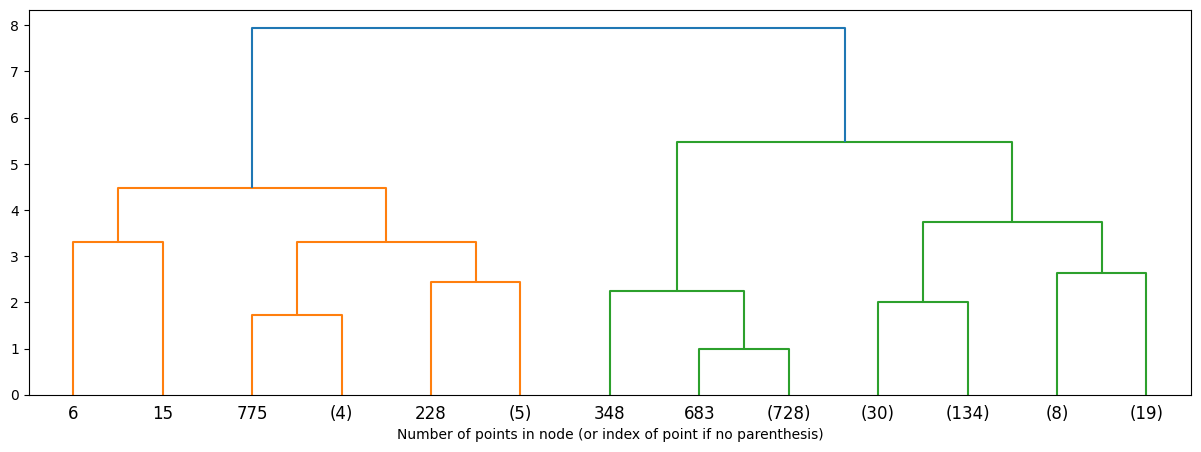

For the interval of  60 clustering time:  0.022687673568725586


In [30]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from dtaidistance import dtw
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

df_expanded = combined_df
data = df_expanded.to_numpy()

# Remove the first column (text)
numeric_data = data[:, 1:].astype(np.float64)

# Compute the pairwise distance matrix using DTW
start = time.time()
print("Computing distance matrix...")
mp = True
distance_matrix = dtw.distance_matrix_fast(numeric_data, use_mp=mp)
end = time.time()
print("Distance matrix computed in: ", end - start, " seconds")
dist_time = end - start

# Perform hierarchical clustering using the distance matrix
start = time.time()
print("Performing hierarchical clustering...")
distance_threshold = 2
n_clusters = None
affinity = 'precomputed'
linkage='complete'
model = AgglomerativeClustering(distance_threshold=distance_threshold, n_clusters=n_clusters, affinity=affinity, linkage=linkage)
model = model.fit(distance_matrix)
end = time.time()
print("Clustering performed in: ", end - start, " seconds")
algo_time = end-start

# Plot the dendrogram
fig, ax = plt.subplots(figsize=(15, 5))
plot_dendrogram(model, truncate_mode='level', p=3, ax=ax)
plt.xlabel("Number of points in node (or index of point if no parenthesis)")
plt.show()

print("For the interval of ", second_interval, "clustering time: ", end - start)

# SET PARAMS FOR SCORING TRACKER
algo = "AgglomerativeClustering"
dist = "dtw"




In [31]:
labels = model.labels_

In [32]:
print(labels)

[ 3  3  4  4  4  3  6  4  2  4  0  0  4  4 10  7  4 10  3  4  4  4  4  4
  4  4  3  4  4  3  4  4  4  4  3  3  4  4  4  1  4  4  0  4  4  4  4  4
  3  4  4  4  4  4  4  4  4  4  4  4  3  4  4  4  4  4  4  4  4  4  5  3
  4  4  4  1  4  4  4  4  4  4  4  4  4  4  4  2  1  4 10  4  4  4  4  4
  5  4  4  3  4  0  3 10  4  3  4  3  4  4  4  4  4  4  0  4  4  3  4  4
  3  4 10  4  4  3  4  4  4  3  4  4  4  3  4  5  4  4  0  4  4  4  3  3
  0  4  3  0  3  4  3  4  4  4  4  4  3  4  3  4  3  4  4  4  3  4  4  4
  4  3  3  3  4  4  3  4  4  4  4  4  3  3  4  4 10  4  4  4  3  1  4  4
  4  4  3  4  4  3  4  4  4  4  4  4  4 10  4  4  3  4  4  4  3  4  3  4
  4  4 10  4  3  4  4  2  4  4  4  4  8  4  4  3  3  0  4 10  4  3  4  4
  4 10 10  3  4  4 10  3  3  4  4  4  4  3  4  4  4  4  3  4  4  4  3  4
  4  4  4  4  4  4  5  4  4  4  4  4 10  3  4  3  3  4  4  4  4  4  4  3
  4  3  4  0  3  4 10  4  3 10  4  4  3  4  4 10  3 10  4  4  4  4  4  4
  3  4  4  4  4  4  3  3  3  4  4  4  4  3  4  5  4

In [33]:
np.savetxt("labels.csv", labels, delimiter=",")

In [34]:
from sklearn import metrics

#Silhouette Score: Measures how close each sample in one cluster is to the samples in the neighboring clusters. The best value is 1 and the worst value is -1.
#Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.
silhouette_score = metrics.silhouette_score(distance_matrix, labels, metric='precomputed')

#Calinski-Harabasz Index: Also known as the Variance Ratio Criterion, it is the ratio of the sum of between-clusters dispersion and of inter-cluster dispersion for all clusters.
#The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.
calinski_harabasz_score = metrics.calinski_harabasz_score(numeric_data, labels)

#Davies-Bouldin Index: It is defined as the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances.
#The minimum score is zero, with lower values indicating better clustering.
davies_bouldin_score = metrics.davies_bouldin_score(numeric_data, labels)

print('Silhouette Score (1 is best): ', silhouette_score)
print('Calinski Harabasz Score (higher is better): ', calinski_harabasz_score)
print('Davies Bouldin Score (lower is better): ', davies_bouldin_score)


Silhouette Score (1 is best):  0.9014791723784734
Calinski Harabasz Score (higher is better):  21.062482985282887
Davies Bouldin Score (lower is better):  4.001509747896008


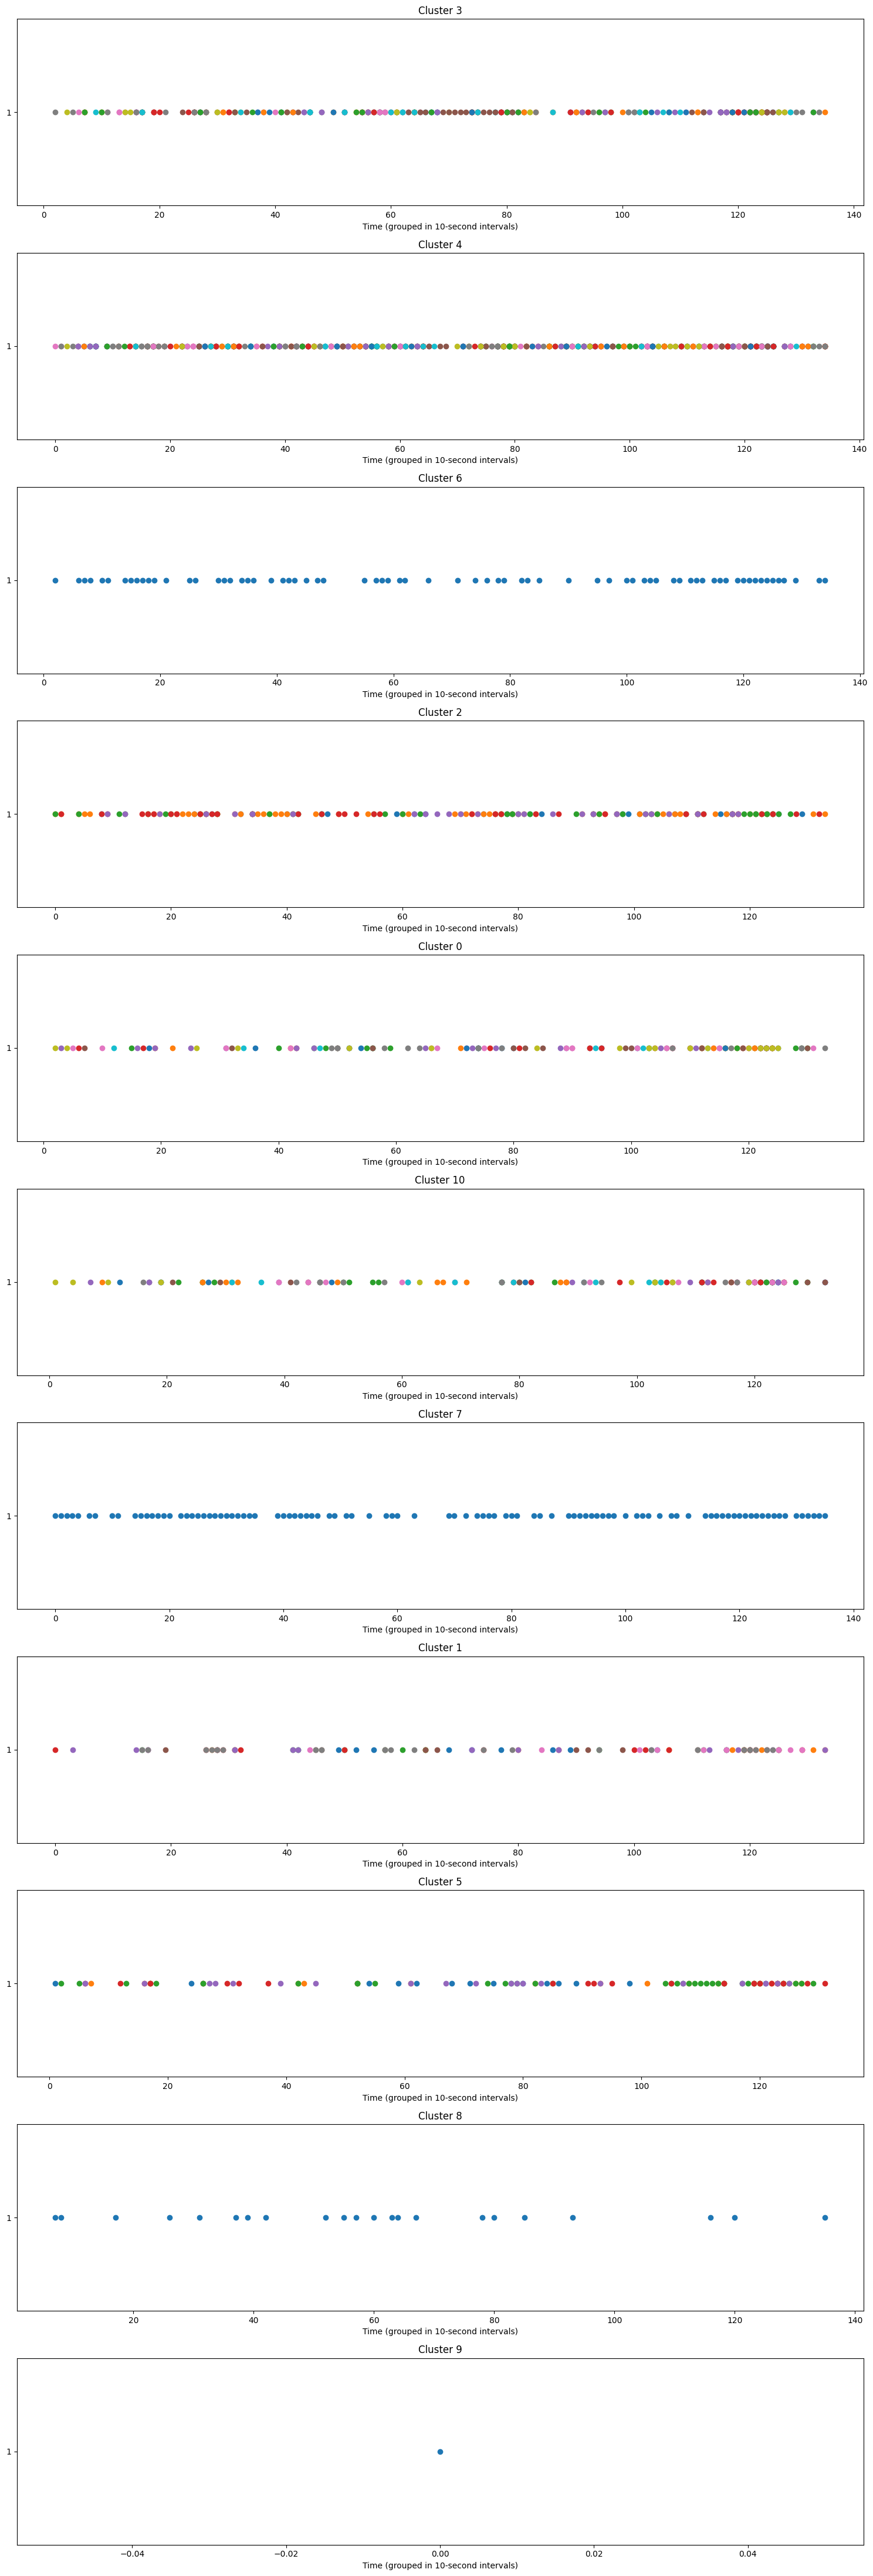

In [35]:
# Create a dictionary to store data of each cluster
clusters = {}
for i, label in enumerate(labels):
    if label not in clusters:
        clusters[label] = []
    clusters[label].append(numeric_data[i])

# Calculate the number of rows and columns for the grid of plots
n_labels = len(clusters)

# Set the size of the entire figure
plt.figure(figsize=(15, 4 * n_labels))

# Plot the data for each cluster in a grid
for idx, (label, data) in enumerate(clusters.items(), start=1):
    ax = plt.subplot(n_labels, 1, idx)
    for row in data:
        ones_indices = np.where(row == 1)
        ax.scatter(ones_indices, np.ones_like(ones_indices), marker='o')
    ax.set_title(f"Cluster {label}")
    ax.set_xlabel("Time (grouped in 10-second intervals)")
    ax.set_ylim(0, 2)
    ax.set_yticks([1])
    ax.set_yticklabels(['1'])

plt.tight_layout()
plt.show()




In [36]:
num_labels = n_labels

In [37]:

# # Create a dictionary to store data of each cluster
# clusters = {}
# for i, label in enumerate(labels):
#     if label not in clusters:
#         clusters[label] = []
#     clusters[label].append(numeric_data[i])

# # Set the size of the figure
# plt.figure(figsize=(15, 4))

# # Define the colors for each cluster
# colors = plt.cm.get_cmap('viridis', len(clusters))

# # Define the text for each cluster - hardcoded WILL NOT WORK WITH EACH INTERATION
# cluster_texts = {
#     0: ":_fusAD:, :_fusApril::_fusApril:, :_fusBlind:",
#     1: ":_fus7::_fus7::_fus7:, :_fus7:see, :_fusComfy::_fusComfy::_fus7:",
#     2: ":_fusPat:, AINTNOWAY, AYO",
#     3: ":skull:, :_fusD::_fusD::_fusD:, Ahhahaa",
#     4: ":rolling_on_the_floor_laughing::rolling_on_the_floor_laughing::rolling_on_the_floor_laughing::rolling_on_the_floor_laughing, AYOOO",
#     5: "Woooooo, Yesssss, wideVIBE, !@Green",
#     6: "AHAHAHAHA, BIGWOW, Broooo, Canâ€™t",
#     7: ":_fusKeK:, :rolling_on_the_floor_laughing:, ????",
#     8: "..., :_fusKeK:, :_fusOMEGA:"
# }

# # Plot the data for each cluster with a different color
# for idx, (label, data) in enumerate(clusters.items()):
#     for row in data:
#         ones_indices = np.where(row == 1)
#         plt.scatter(ones_indices, np.full_like(ones_indices, idx), marker='o', color=colors(idx), label=f"Cluster {label}: {cluster_texts[label]}" if idx == 0 else None)

# plt.xlabel("Time (grouped into intervals)")
# plt.ylim(-1, len(clusters))
# plt.yticks(range(len(clusters)), [f"Cluster {label}" for label in clusters.keys()])
# plt.tight_layout()

# # Add the legend at the bottom of the plot
# legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=f"Cluster {label}: {cluster_texts[label]}", markerfacecolor=colors(idx), markersize=8) for idx, label in enumerate(clusters.keys())]
# plt.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.25), loc='upper center', ncol=3)

# plt.show()





In [38]:
df_expanded.to_csv("messages.csv")

In [39]:
#add interation to score tracker

######################################
#REMEMBER TO ADD NOTES & TESTING PHASE
######################################

testing_phase = "clustering with power series filtering"
notes = "maintaining sentences and lowering fuzz ratio"

import csv

# Open the file in append mode ('a')
with open('score_tracker.csv', 'a', newline='') as f:
    writer = csv.writer(f)
    writer.writerow([testing_phase, date_time, n_messages, second_interval,fuzz_ratio, data_size, algo, algo_time, dist, dist_time, mp, distance_threshold, n_clusters, affinity, linkage, num_labels, silhouette_score, calinski_harabasz_score, davies_bouldin_score, notes])


In [40]:
dtw.try_import_c(verbose=True)

All ok ...
== Packages ==
- Numpy version: 1.22.4
- Matplotlib version: 3.7.1
- Scipy version: 1.10.1
== System information ==
namespace(name='cpython', cache_tag='cpython-310', version=sys.version_info(major=3, minor=10, micro=12, releaselevel='final', serial=0), hexversion=50990320, _multiarch='x86_64-linux-gnu')
== Compilation information ==
Compiler type: unix
--noopenmp: 0
--forceopenmp: 0
--noxpreprocessor: 0
--forcellvm: 0
--forcegnugcc: 0
--forcestatic: 0
Cython found (during compilation)
- Version: 0.29.32
- Locations: <module 'Cython' from '/tmp/pip-build-env-l2jmr8ns/overlay/lib/python3.10/site-packages/Cython/__init__.py'>
Numpy found (during compilation):
- Version: 1.23.3
- Location: <module 'numpy' from '/tmp/pip-build-env-l2jmr8ns/overlay/lib/python3.10/site-packages/numpy/__init__.py'>
Checking if gcc redirects to clang
gcc --version # with stdout=-1, stderr=-1, input=, encoding=ascii

Using GNU GCC settings (gcc)
Checking for OpenMP availability for gcc
gcc -dM -E -Xp

True